In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-data-for-ml-course/train.csv.gz
/kaggle/input/home-data-for-ml-course/test.csv
/kaggle/input/home-data-for-ml-course/sample_submission.csv
/kaggle/input/home-data-for-ml-course/test.csv.gz
/kaggle/input/home-data-for-ml-course/sample_submission.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv
/kaggle/input/home-data-for-ml-course/data_description.txt


## STEP 1: load in the dataset and conduct data exploratory analysis

In [2]:
# the reason we should not include index in the training set is because we are passing every columns into XGBoost, including ID can have overfitting problems
# there is really a huge huge difference!

train_df = pd.read_csv("../input/home-data-for-ml-course/train.csv",index_col=0) 
test_df = pd.read_csv("../input/home-data-for-ml-course/test.csv",index_col=0)

In [3]:
train_df_copy = train_df.copy()
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0bc76f8e10>,
      dtype=object)

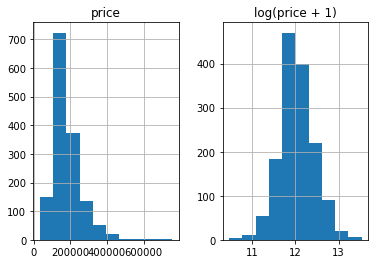

In [4]:
%matplotlib inline
prices = pd.DataFrame({"price":train_df["SalePrice"], "log(price + 1)":np.log1p(train_df["SalePrice"])})
prices.hist()

## STEP 2: Split the X and Y,and concat test dataset for cleaning purposes

In [5]:
# before concating test and train, we need to first pop out the Y column, otherwise their dimensions cannot match
train_y=np.log1p(train_df.pop("SalePrice"))

In [6]:
# Let's see the shape of all_df before and after concatenation
print(f'train_df shape:{train_df.shape}, and test_df shape:{test_df.shape}')
all_df = pd.concat([train_df,test_df],axis=0)
print(f'after concatenation: all_df shape:{all_df.shape}')

train_df shape:(1460, 79), and test_df shape:(1459, 79)
after concatenation: all_df shape:(2919, 79)


## STEP 3: Data cleaning, null value imputations

### 3-1. Null detection and inputation

In [7]:
# how many null values?
print(all_df.isnull().sum().sum())
all_df.isnull().sum().sort_values(ascending = False).head(10)

13965


PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
FireplaceQu     1420
LotFrontage      486
GarageCond       159
GarageQual       159
GarageYrBlt      159
GarageFinish     159
dtype: int64

In [8]:
all_df.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MiscVal            int64
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
Length: 79, dtype: object

In [9]:
# we use KNN for all non-categorical columns to deal with nulls
all_df_val = all_df.loc[:,all_df.dtypes != "object"]

from sklearn.impute import KNNImputer
KNN_imputer = KNNImputer(n_neighbors = 2)
copy_index = all_df_val.index
copy_columns = all_df_val.columns
all_df_val = pd.DataFrame(KNN_imputer.fit_transform(all_df_val),index = copy_index,columns=copy_columns)
all_df.loc[:,all_df.dtypes != "object"]  = all_df_val

print(f'Now our non-categorical cols has: {all_df_val.isnull().sum().sum()} null values')

Now our non-categorical cols has: 0 null values


For those categorical variables, we simply convert NaN to "missing"

In [10]:
all_df.loc[:,all_df.dtypes == "object"] = all_df.fillna("missing")
print(f'Now our overall all_df has: {all_df.isnull().sum().sum()} null values')

Now our overall all_df has: 0 null values


### Before conducting OHE, I would first explore the categorical variables' dimensions. Then, I will create new segregation for those high-dimension columns
The idea is explorting patterns using train_df only (since we need to include SalePrice), and apply the matching relationship in all_df.

In [11]:
# slice only the object columns
all_df_obj = all_df.loc[:,all_df.dtypes == "object"]

# we need to shrink the dimensions for Neighborhood/MSSubClass/Exterior2nd/Exterior1st
# so that there wouldn't be that much dummies under OHE.
dummy_dim = all_df_obj.nunique().sort_values(ascending = False)
dummy_dim.head(5)

# record these several high-dimension columns
obj_features = ["Neighborhood","MSSubClass","Extebrior2nd","Exterior1st"]

In [12]:
def get_new_segment(train_df_copy, high_dim_col):
    '''
    This function takes a training dataframe as input, returns a dictionary with original values as keys
    and the corresponding new segments as values
    
    new segments includes "very high price", "high price", "mid price", "low price", "very low price"
    
    Input:
        train_df, high_dim_col(string)
    Output:
        new_seg(dict)
    '''
    # transform price into log_price
    train_df_copy.SalePrice = np.log1p(train_df_copy.SalePrice)
    
    
    train_df_col_avg_price = pd.DataFrame(train_df_copy.groupby(high_dim_col).SalePrice.mean())
    train_df_col_avg_price.loc[train_df_col_avg_price.SalePrice >= np.percentile(train_df_copy.SalePrice,80),"new_seg_col"] = "very high price"
    train_df_col_avg_price.loc[(train_df_col_avg_price.SalePrice >= np.percentile(train_df_copy.SalePrice,60)) & (train_df_col_avg_price.SalePrice < np.percentile(train_df_copy.SalePrice,80)),"new_seg_col"] = "high price"
    train_df_col_avg_price.loc[(train_df_col_avg_price.SalePrice >= np.percentile(train_df_copy.SalePrice,40)) & (train_df_col_avg_price.SalePrice < np.percentile(train_df_copy.SalePrice,60)),"new_seg_col"] = "mid price"
    train_df_col_avg_price.loc[(train_df_col_avg_price.SalePrice >= np.percentile(train_df_copy.SalePrice,20)) & (train_df_col_avg_price.SalePrice < np.percentile(train_df_copy.SalePrice,40)),"new_seg_col"] = "low price"
    train_df_col_avg_price.loc[train_df_col_avg_price.SalePrice < np.percentile(train_df_copy.SalePrice,20),"new_seg_col"] = "very low price"
    
    # create a new_seg dictionary
    new_seg = dict(zip(train_df_col_avg_price.index, train_df_col_avg_price.new_seg_col))
    return new_seg

def transform_high_dim_col(all_df, high_dim_col, new_seg):
    '''
    This function takes a concatenated all_df and high_dim_col name for transformation
    '''
    def get_seg_value(key):
        '''
        for those scenarios that, some values only appear in test_df, not in train_df, we just store them in unknown category
        '''
        try:
            new_value = new_seg[key]
        except:
            new_value = "unknown"
        return new_value
    
    all_df[high_dim_col] = list(map(get_seg_value, all_df[high_dim_col]))
    return all_df    
    

In [13]:
obj_features = ["Neighborhood","MSSubClass","Exterior2nd","Exterior1st"]
for high_dim_col in obj_features:
    new_seg = get_new_segment(train_df_copy, high_dim_col)
    print(f'Now we have got a new segment for {high_dim_col}')
    all_df = transform_high_dim_col(all_df, high_dim_col, new_seg)
    print(f'hooray! we have transformed the {high_dim_col}')
    
# Let's take a look at the transformed features
all_df[obj_features]

Now we have got a new segment for Neighborhood
hooray! we have transformed the Neighborhood
Now we have got a new segment for MSSubClass
hooray! we have transformed the MSSubClass
Now we have got a new segment for Exterior2nd
hooray! we have transformed the Exterior2nd
Now we have got a new segment for Exterior1st
hooray! we have transformed the Exterior1st


,Neighborhood,MSSubClass,Exterior2nd,Exterior1st
Id,,,,
1,high price,high price,high price,high price
2,high price,mid price,low price,low price
3,high price,high price,high price,high price
4,high price,mid price,low price,low price
5,very high price,high price,high price,high price
...,...,...,...,...
2915,very low price,low price,high price,high price
2916,very low price,low price,high price,high price
2917,mid price,mid price,high price,high price


### 3-1. one hot encoding****

In [14]:
all_df_dummies=pd.get_dummies(all_df)
all_df_dummies.shape

(2919, 274)

### 3-3. Normalize numerical independent variables

In [15]:
all_df_dummies.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_missing,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,150.0,...,0,0,1,0,0,0,0,0,1,0
2,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,284.0,...,0,0,1,0,0,0,0,0,1,0
3,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,434.0,...,0,0,1,0,0,0,0,0,1,0
4,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,540.0,...,0,0,1,0,1,0,0,0,0,0
5,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,490.0,...,0,0,1,0,0,0,0,0,1,0


In [16]:
numerical_cols = all_df.columns[all_df.dtypes!="object"] #this just return the 'names' of these numerical columns
numerical_cols_mean = all_df.loc[:,numerical_cols].mean()
numerical_cols_std = all_df.loc[:,numerical_cols].std()  #if we want to pass in names of the columns, we need to use '.loc[]'
updated_numerical_cols=(all_df.loc[:,numerical_cols]-numerical_cols_mean)/numerical_cols_std

#then pass these updated numerical values to all_df_dummies
all_df_dummies[updated_numerical_cols.columns]=updated_numerical_cols

## STEP 4: Modeling

### 4-1. Split train_test

In [17]:
X_train = all_df_dummies.iloc[train_df.index-1] #since we are slicing using 'index',so we need to use loc instead of iloc
Y_train = train_y
X_test = all_df_dummies.iloc[test_df.index-1] #since we are slicing using 'index',so we need to use loc instead of iloc 

### 4-2. build Ensemble (using XGBoost here)

In [18]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

In [19]:
X_train.shape,Y_train.shape

((1460, 274), (1460,))

## STEP 5: Fit the model using whole dataset, submit the prediction

In [20]:
from sklearn.model_selection import GridSearchCV

clf = XGBRegressor(n_estimators = 1000)
parameters = {"learning_rate": [0.01,0.03,0.05], "max_depth":[2,4,5,6]}
grid_search = GridSearchCV(clf, parameters, n_jobs = -1, cv=5, scoring="neg_mean_squared_error")
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=1000, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_par

In [21]:
print(grid_search.best_params_)
clf_best = grid_search.best_estimator_
print(clf_best.score(X_train, Y_train))

{'learning_rate': 0.05, 'max_depth': 2}
0.9660922198122409


In [22]:
feature_importances = pd.DataFrame(clf_best.feature_importances_)
feature_importances.index = X_train.columns
feature_importances = feature_importances.sort_values(0,ascending=False)
feature_importances

,0
Neighborhood_very low price,0.107887
GarageCars,0.104222
BsmtQual_Ex,0.091357
Neighborhood_very high price,0.068020
GarageType_Attchd,0.057458
...,...
LandContour_HLS,0.000000
Foundation_CBlock,0.000000
Foundation_Slab,0.000000
Foundation_Stone,0.000000


In [23]:
X_train_shrink = X_train[feature_importances.index[:int(len(feature_importances)/3)]]
X_test_shrink = X_test[feature_importances.index[:int(len(feature_importances)/3)]]

parameters = {"learning_rate": [0.01,0.03,0.05], "max_depth":[2,4,5,6]}
grid_search = GridSearchCV(clf, parameters, n_jobs = -1, cv=5, scoring="neg_mean_squared_error")
grid_search.fit(X_train_shrink, Y_train)

print(grid_search.best_params_)
clf_best = grid_search.best_estimator_
print(clf_best.score(X_train_shrink, Y_train))

{'learning_rate': 0.05, 'max_depth': 2}
0.9654180559926093


In [25]:
test_y_2nd = np.expm1(clf_best.predict(X_test_shrink))
test_y_2nd

array([121610.95, 162488.75, 183871.5 , ..., 170394.81, 116142.57,
       234469.62], dtype=float32)

In [26]:
submission_v2 = pd.DataFrame({"Id":X_test.index,"SalePrice":test_y_2nd})
submission_v2.head(10)
submission_v2.to_csv("submission.csv",index=False)